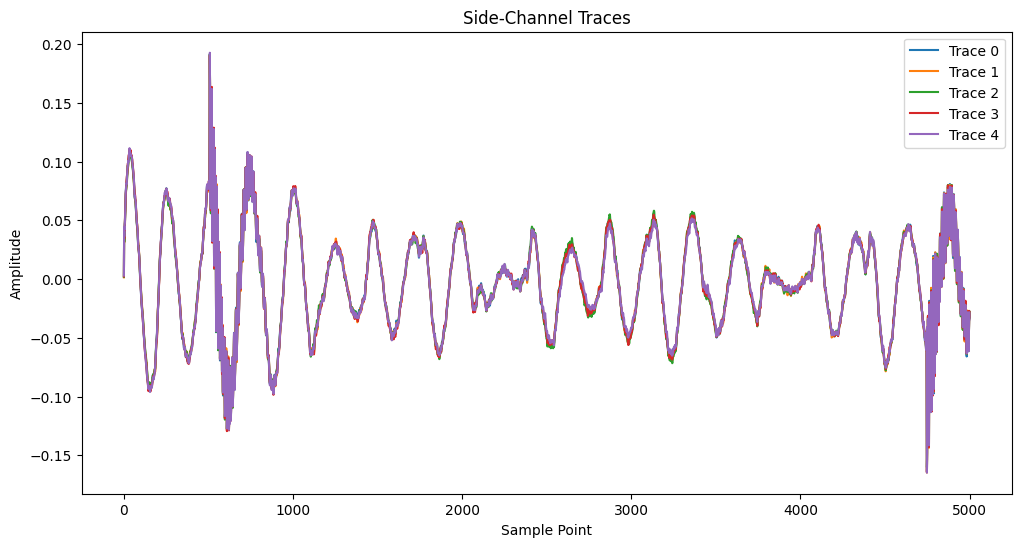

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import struct

traces = np.load("cleaned_avg_traces300.npy")
inputs = np.load("cleaned_avg_entries300.npy")

    
# Visualize some traces
plt.figure(figsize=(12, 6))
for i in range(5):  # Adjust the range as needed
    plt.plot(traces[i], label=f'Trace {i}')
plt.title('Side-Channel Traces')
plt.xlabel('Sample Point')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

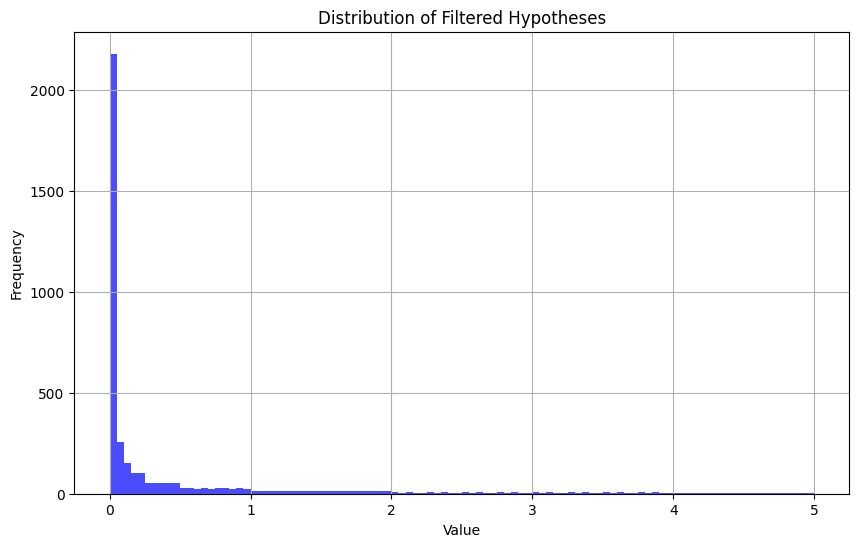

(3881, [0.0, 1e-06, 2e-06, 3e-06, 4e-06, 5e-06, 6e-06, 7e-06, 8e-06, 9e-06])

In [2]:
import struct

# Define the precision threshold for filtering
precision_threshold = 0.01

# Define the range for NN weights (for this example, we'll use 0 to 5)
min_value = 0
max_value = 5

# Generate hypotheses
unique_values = set()
for exponent in range(256):  # 8 bits for the exponent
    for mantissa in range(256):  # 8 most significant bits for the mantissa
        # Construct the binary representation of the float
        # Here, we are assuming a simplified model where the exponent is not biased
        # and the leading bit of the mantissa is set according to the sign (positive in this case)
        binary_str = '0' + format(exponent, '08b') + format(mantissa, '08b') + '0' * 15
        # Convert to a floating-point number using numpy's view casting
        float_num = struct.unpack('!f', struct.pack('!I', int(binary_str, 2)))[0]
        # Round the number to the specified precision
        rounded_num = round(float_num, 6)
        # Filter based on the range (0 to 5) and precision
        if min_value <= rounded_num <= max_value:
            unique_values.add(rounded_num)

# Convert the set of unique values to a sorted list
hypotheses_list = sorted(list(unique_values))

# Plot the filtered and rounded hypotheses
plt.figure(figsize=(10, 6))
plt.hist(hypotheses_list, bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Filtered Hypotheses')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Output the number of unique values for verification
len(hypotheses_list), hypotheses_list[:10]  # Show the first 10 hypotheses for inspection


In [3]:
hypothetical_weights = hypotheses_list



C:\Users\zqde8\AppData\Local\Temp\ipykernel_16444\2445488633.py:23: RuntimeWarning: overflow encountered in multiply
  hws = [hamming_weight(float_to_binary(input_value * weight)) for input_value in inputs]


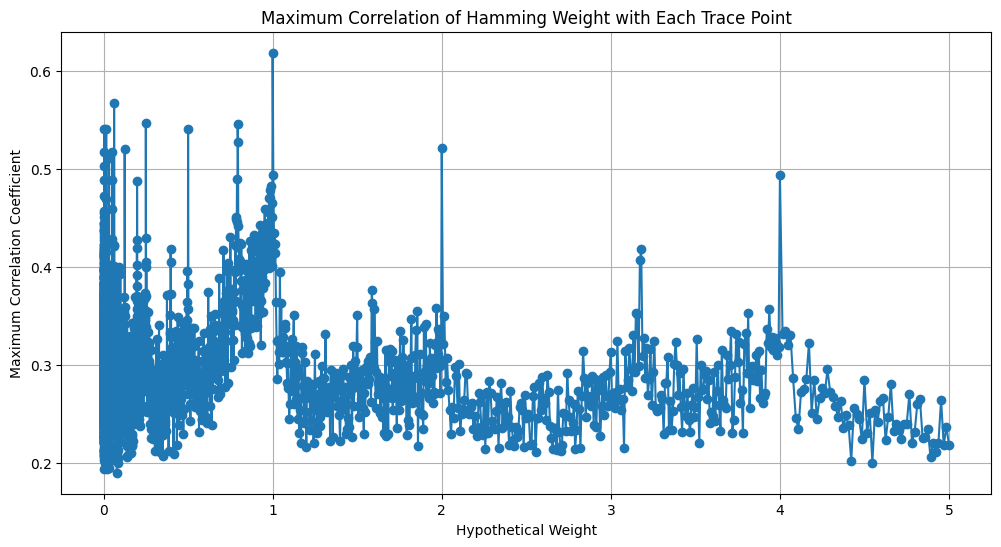

In [4]:
from tqdm.notebook import tqdm
# Analyze a trace
#selected_trace = traces[0]
#input_value = inputs[0]

def float_to_binary(num):
    """Convert a floating point number to its binary representation in IEEE 754 format."""
    return ''.join(f'{c:08b}' for c in struct.pack('!f', num))

def hamming_weight(binary_str):
    """Calculate the Hamming weight (number of '1's) in the binary string."""
    return binary_str.count('1')

# Number of sample points in each trace
num_sample_points = traces.shape[1]

# Initialize an array to hold the maximum correlation for each hypothetical weight
max_correlations = np.zeros(len(hypothetical_weights))

# Loop over each hypothetical weight
for index, weight in enumerate(hypothetical_weights):
    # Compute the HW for each input multiplied by the hypothetical weight
    hws = [hamming_weight(float_to_binary(input_value * weight)) for input_value in inputs]

    # Compute correlation for each sample point and find the maximum correlation
    correlations = np.array([pearsonr(traces[:, sample_point], hws)[0] for sample_point in range(num_sample_points)])
    
    # Handle NaN values
    correlations = np.nan_to_num(correlations)

    # Find the maximum correlation for this hypothetical weight
    max_correlations[index] = np.max(np.abs(correlations))
    print(f"Progress: {index+1}/{len(hypothetical_weights)}", end='\r')
# Plotting the maximum correlations against hypothetical weights
plt.figure(figsize=(12, 6))
plt.plot(hypothetical_weights, max_correlations, marker='o')
plt.title('Maximum Correlation of Hamming Weight with Each Trace Point')
plt.xlabel('Hypothetical Weight')
plt.ylabel('Maximum Correlation Coefficient')
plt.grid()
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers(hypothetical_weights, max_correlations):
    q25, q75 = np.percentile(max_correlations, [25, 75])
    iqr = q75 - q25

    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr

    filtered_weights = []
    filtered_correlations = []
    for weight, correlation in zip(hypothetical_weights, max_correlations):
        if lower_bound < correlation < upper_bound:
            filtered_weights.append(weight)
            filtered_correlations.append(correlation)

    return np.array(filtered_weights), np.array(filtered_correlations)

def plot_correlations(hypothetical_weights, max_correlations):
    # Remove outliers
    filtered_weights, filtered_correlations = remove_outliers(hypothetical_weights, max_correlations)

    plt.figure(figsize=(12, 6))
    plt.plot(filtered_weights, filtered_correlations, marker='o')
    plt.title('Maximum Correlation of Hamming Weight with Each Trace Point (Outliers Removed)')
    plt.xlabel('Hypothetical Weight')
    plt.ylabel('Maximum Correlation Coefficient')
    plt.grid()
    plt.show()




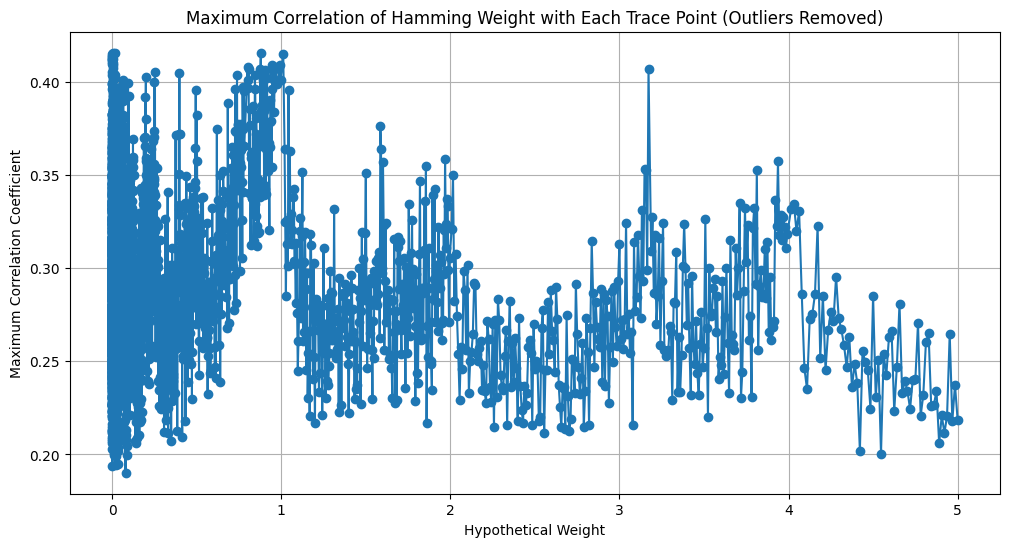

In [9]:
plot_correlations(hypothetical_weights, max_correlations)

In [10]:
def moving_average(data, window_size):
    """Calculate the moving average over a specified window size."""
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)


In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_correlations_with_smoothing(hypothetical_weights, max_correlations, window_size=5):
    # Apply moving average smoothing
    smoothed_correlations = moving_average(max_correlations, window_size)

    # Adjust hypothetical_weights to match the size of smoothed_correlations
    # Since moving average reduces the size of the data, we need to trim the weights array
    adjusted_weights = hypothetical_weights[:len(smoothed_correlations)]

    plt.figure(figsize=(12, 6))
    plt.plot(adjusted_weights, smoothed_correlations, marker='o')
    plt.title('Smoothed Maximum Correlation of Hamming Weight with Each Trace Point')
    plt.xlabel('Hypothetical Weight')
    plt.ylabel('Smoothed Maximum Correlation Coefficient')
    plt.grid()
    plt.show()


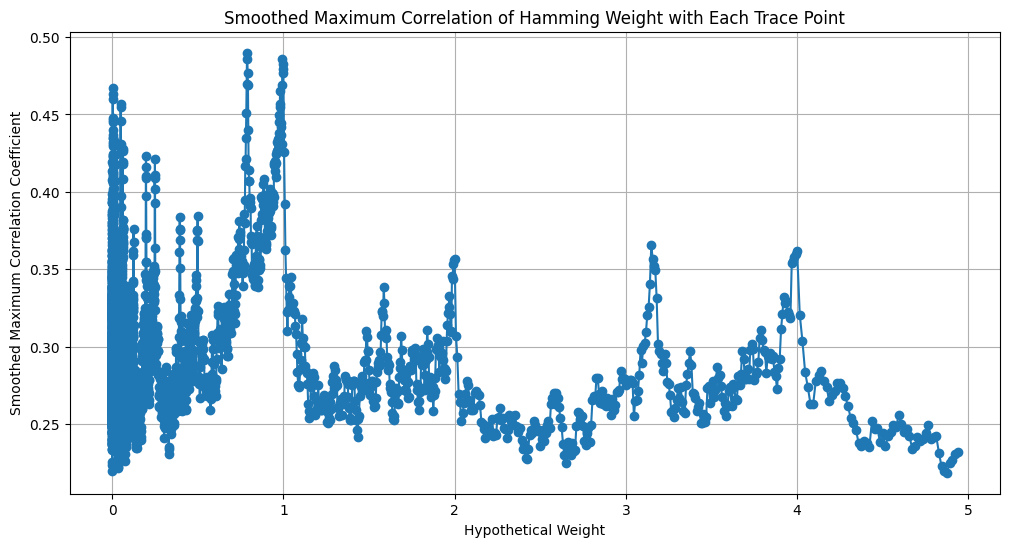

In [20]:
plot_correlations_with_smoothing(hypothetical_weights, max_correlations)